In [ ]:
# Plotting radio-to-K-band(2.2um) flux density ratio as a function of redshift, using S150/S2.2um
# This code provides a modification of a plot done as part of the Curtin University unit "PHYS3003 Physics Project", supervised by Nick Seymour and Jess Broderick (CIRA)
# This plot has been prepared for inclusion in a peer-reviewed article submitted to the Publications of the Astronomical Society of Australia.

# Last modified: 3/2/2021

In [ ]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 
from astropy.cosmology import Planck15,z_at_value
import astropy.units as u
import astropy.io.fits as fits
import csv
import pandas as pd

In [ ]:
# initialise files for import/plotting (only data on Radio Galaxies, with all other sources excluded)

# read in source data, provided Sem 1, 2020
hzrg_3c=np.genfromtxt('drouart 3c.csv',delimiter=",",usecols=(1,2,6,8),names=True,dtype=None)
hzrg_6c=np.genfromtxt('drouart 6c.csv',delimiter=",",usecols=(1,2,4,6,8),names=True,dtype=None)
hzrg_sample=np.genfromtxt('drouart hzrgs.csv',delimiter=",",usecols=(1,2,6,8),names=True,dtype=None)
hzrg_saxena=np.genfromtxt('Saxena data.csv',delimiter=",",usecols=(1,2,6,4,8),names=True,dtype=None)
hzrg_drouart=np.genfromtxt('drouart 2020.csv',delimiter=",",usecols=(1,2,4,6,8),names=True,dtype=None)

# Import RL, RQ sample et al (provided by Nick)
rl_ratio=np.genfromtxt('rl_ratio.csv',delimiter=",",usecols=(0,1),names=True,dtype=None)
rq_ratio=np.genfromtxt('rq_ratio.csv',delimiter=",",usecols=(0,1),names=True,dtype=None)
qso_ratio=np.genfromtxt('150K_ratio.csv',delimiter=",",usecols=(0,2,3),names=True,dtype=None)

# import new data for paper (Jan 2021). Data includes QSOs at redshift greater than 6 (zgt6)
qso_zgt6 = np.genfromtxt('zgt6qso.txt',comments=None,delimiter=None,names=True,dtype=None,encoding=None) 
qso_zgt6['K'] = qso_zgt6['K']+1.85 # change magnitudes from K[Vega] to K[AB]

# GLEAM AGN sample (Franzen et al in prep.)
local_AGN=np.genfromtxt('local_AGN.csv',delimiter=",",names=True,dtype=None,encoding=None)

In [ ]:
# Functions

# Convert mag (AB) to flux (Jy)
def mag2flux(mag):
    for value in mag:
        try:
            flux_conv = 10**(26-(mag+48.6)/2.5)
            return flux_conv
        except:
            continue

# Convert flux (Jy) to AB mag            
def flux2mag(flux):
    return -2.5*np.log10(flux)+8.9

# Calculate Luminosity @ 1400MHz using flux (mJy), redshift, alpha
def L1400(redshift, flux, alpha):
    for value in redshift:
        try:
            flux=flux * 1e-29 *(u.W / (u.m*u.m) / u.Hz) #convert flux from mJy to W/m^2/Hz
            redshift = redshift * u.dimensionless_unscaled
            dL = Planck15.luminosity_distance(redshift).to(u.m) #convert Mpc to metres
            alpha=alpha * u.dimensionless_unscaled
            lum_1400 = 4.*np.pi*dL*dL*flux*((1+redshift)**-(1+alpha))
            return lum_1400
        except:
            continue

# Extrapolate S_150 MHz using alpha and S_1400 MHz (mJy)
def S150(S1400,alpha):
    for value in S1400:
        try:
            S1400=S1400 * 1e-29 *(u.W / (u.m*u.m) / u.Hz) #convert S_1400 flux from mJy to W/m^2/Hz
            alpha=alpha * u.dimensionless_unscaled
            S_150 = S1400*(150/1400)**alpha # extrapolate S150 from S1400 and alpha values
            return S_150
        except:
            continue

# Calculate Luminosity @ 150 MHz using S_150 MHz (mJy)          
def L150(S150,redshift): # Assumes S_150 is correctly in SI units after processing by the 'S150' method
    for value in S150:
        try:
            redshift = redshift * u.dimensionless_unscaled
            dL = Planck15.luminosity_distance(redshift).to(u.m) #convert Mpc to metres
            lum_150 = 4.*np.pi*dL*dL*(S150/(1+redshift))
            return lum_150
        except:
            continue

# Calculate flux/2.2um ratio code
def flux_ratio(S150,Kflux):
    for value in S150:
        try:
            Kflux=Kflux * 1e-29 *(u.W / (u.m*u.m) / u.Hz) #convert flux from mJy to W/m^2/Hz
            ratio_150 = np.divide(S150,Kflux)
            return ratio_150
        except:
            continue
            
# convert S1400/S3.2um to S150/S2.2um, alpha= -0.8
def ratio_convert(ratio): 
    for value in ratio: 
        try:
            log_conv = np.exp(ratio) # "normalise" log ratio, ie. S1400/S3.2um
            s150_ratio = log_conv*(150/1400)**(-0.8) # Sv = Sv0*(v/v0)^alpha
            return s150_ratio 
        except:
            continue

In [ ]:
# Could this code be optimised?

# Variables for 3C objects
z_3c = hzrg_3c['z']
s1400_3c = hzrg_3c['S1400']
alpha_3c = hzrg_3c['alpha']
K_3c = hzrg_3c['K']
Kflux_3c = mag2flux(K_3c) # convert K mag into flux
s150_3c = S150(s1400_3c,alpha_3c) # extrapolate S_150
L150_3c = L150(s150_3c,z_3c) # calc L_500
ratio_3c = flux_ratio(s150_3c,Kflux_3c) # find flux/K ratio

# Variables for 6C objects
z_6c = hzrg_6c['z']
s1400_6c = hzrg_6c['S1400']
alpha_6c = hzrg_6c['alpha']
K_6c = hzrg_6c['K']
Kflux_6c = mag2flux(K_6c)
s150_6c = S150(s1400_6c,alpha_6c)
L150_6c = L150(s150_6c,z_6c)
ratio_6c = flux_ratio(s150_6c,Kflux_6c)

# Variables for 'hzrg' objects
z_hzrg = hzrg_sample['z']
s1400_hzrg = hzrg_sample['S1400']
alpha_hzrg = hzrg_sample['alpha']
K_hzrg = hzrg_sample['K']
Kflux_hzrg = mag2flux(K_hzrg)
s150_hzrg = S150(s1400_hzrg,alpha_hzrg)
L150_hzrg = L150(s150_hzrg,z_hzrg)
ratio_hzrg=flux_ratio(s150_hzrg,Kflux_hzrg)

# Variables for Saxena objects
z_sax = hzrg_saxena['z']
s1400_sax = hzrg_saxena['S1400']
alpha_sax = hzrg_saxena['alpha']
K_sax = hzrg_saxena['K']
Kflux_sax = mag2flux(K_sax)
s150_sax = S150(s1400_sax,alpha_sax)
L150_sax = L150(s150_sax,z_sax)
ratio_sax = flux_ratio(s150_sax,Kflux_sax)

# Variables for Drouart objects
z_drouart = hzrg_drouart['z']
s1400_drouart = hzrg_drouart['S1400']
alpha_drouart = hzrg_drouart['alpha']
K_drouart = hzrg_drouart['K']
Kflux_drouart = mag2flux(K_drouart)
s150_drouart = S150(s1400_drouart,alpha_drouart)
L150_drouart = L150(s150_drouart,z_drouart)
ratio_drouart = flux_ratio(s150_drouart,Kflux_drouart)

# Radio loud sources
z_rl=rl_ratio['z']
s1400_ratio_rl=rl_ratio['ratio']
s150_ratio_rl=ratio_convert(s1400_ratio_rl)

# Radio quiet sources
z_rq=rq_ratio['z']
s1400_ratio_rq=rq_ratio['ratio']
s150_ratio_rq=ratio_convert(s1400_ratio_rq)

In [ ]:
# calculate marker sizes based on L150, using a specified luminosity threshold.

Lum_threshold = 1e27 * u.W / u.Hz #units

Lmarker1 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L150_3c]
Lmarker2 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L150_6c]
Lmarker3 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L150_hzrg]
Lmarker4 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L150_sax]
Lmarker5 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L150_drouart]

In [ ]:
# new source:  MG 1131+0456, K=17.8(Vega), so 17.8(+1.85) in AB
# z=1.849 (unpublished), S1400 = 527 mJy (0.527 Jy), S178 = 2300 mJy (2.3 Jy)
# Ref: http://ned.ipac.caltech.edu/byname?objname=MG%201131%2B0456&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

MG1131_K=17.8+1.85 # K-magnitude
MG1131_z=1.849 * u.dimensionless_unscaled
MG1131_S1400=527 * 1e-29 *(u.W / (u.m*u.m) / u.Hz) #convert flux from mJy to W/m^2/Hz
MG1131_alpha=-0.75 * u.dimensionless_unscaled 

#calculate S150, L150 MHz, flux and ratio
dL_MG1131 = Planck15.luminosity_distance(MG1131_z).to(u.m) #convert Mpc to metres
MG1131_S150 = MG1131_S1400*(150/1400)**MG1131_alpha
MG1131_L150 = 4.*np.pi*dL_MG1131*dL_MG1131*MG1131_S150*((1+MG1131_z)**-(1+MG1131_alpha))
MG1131_Kflux = 10**(26-(MG1131_K+48.6)/2.5)* 1e-29 *(u.W / (u.m*u.m) / u.Hz) #convert mag to flux
MG1131_flux_ratio = np.divide(MG1131_S150,MG1131_Kflux)

# get luminosity marker
Lmarker_MG1131=[60 if (MG1131_L150 - Lum_threshold) > 0 else 10]

In [ ]:
# import Banados QSOs for comparison. From Banados et al 2018.
ban_z=5.84 * u.dimensionless_unscaled
ban_alpha=-1.06 * u.dimensionless_unscaled
ban_S150=163.1 * 1e-29 *(u.W / (u.m*u.m) / u.Hz)
ban_Jmag=20.99+1.85 # safe to assume J-mag = K-mag (for this purpose, anyways...)

# calculate flux, L150 and ratio
dl_ban=Planck15.luminosity_distance(ban_z).to(u.m) #convert Mpc to metres
ban_magflux=10**(26-(ban_Jmag+48.6)/2.5) * 1e-29 *(u.W / (u.m*u.m) / u.Hz)# convert J-mag to flux (mJy)
ban_L150=4.*np.pi*dl_ban*dl_ban*ban_S150*((1+ban_z)**-(1+ban_alpha))
ban_ratio=np.divide(ban_S150,ban_magflux)

# get marker sizes
Lmarker_ban=[60 if (ban_L150 - Lum_threshold) > 0 else 10]

# convert objects in "qso_ratio" to L150 for marker adjustment
z_qso=qso_ratio['z']
s150_qso=qso_ratio['Total_flux'] * 1e-29 *(u.W / (u.m*u.m) / u.Hz)
dl_qso=Planck15.luminosity_distance(z_qso).to(u.m)
L150_qso=4.*np.pi*dl_qso*dl_qso*(s150_qso/(1+z_qso))

# get marker sizes
Lmarker_QSO=[60 if (value - Lum_threshold) >= 0 else 10 for value in L150_qso]

In [ ]:
# Calculate Luminosity of qso_zgt6 dataset and assign marker size

qso_zgt6_S150 = qso_zgt6['S150'] * 1e-29 *(u.W / (u.m*u.m) / u.Hz) # convert to SI units
qso_zgt6_L150 = L150(qso_zgt6_S150,qso_zgt6['redshift'])

Lmarker_zgt6=[60 if (value - Lum_threshold) >= 0 else 10 for value in qso_zgt6_L150] 

In [ ]:
# convert local_AGN for plotting and set marker size

S151_local_AGN = local_AGN['S_151'] * 1e-29 *(u.W / (u.m*u.m) / u.Hz) # convert to SI units
L150_local_AGN = L150(S151_local_AGN,local_AGN['z'])
Kflux_local_AGN = local_AGN['Kflux'] * 1e-26 *(u.W / (u.m*u.m) / u.Hz) # convert to SI units
ratio_local_AGN = np.divide(S151_local_AGN,Kflux_local_AGN)

Lmarker_local_AGN=[60 if (value - Lum_threshold) >= 0 else 10 for value in L150_local_AGN] # set marker size

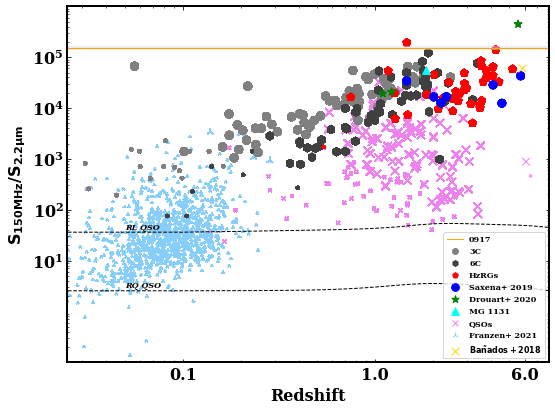

In [ ]:
# Plot the data

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 600
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelweight'] = 600
plt.rcParams['axes.titlesize'] = 'x-large'

# Set up subplots for each data set
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
plt.yscale('log')
plt.xscale('log')

# format x-axis 
plt.xlim([0.025, 8])
plt.xticks([1, 2, 3, 4, 5, 6])
plt.xticks([0.1, 1, 6])
plt.xlabel('Redshift')

# remove scientific notation from x-axis
from matplotlib.ticker import ScalarFormatter
sf = ScalarFormatter()
sf.set_scientific(False)
ax.xaxis.set_major_formatter(sf)

#format y-axis
plt.ylim(0.1, 10**6)
plt.yticks([10, 100, 1000, 10**4, 10**5])
plt.ylabel(r'$\mathrm{{S}_{150MHz} / {S}_{2.2 \mu m}}$')

ax.tick_params(direction='in', which='both', top=True,bottom=True,right=True,left=True, labelbottom=True,labelleft=True)

#
### Is there some way to optimise this next bit? ###
#

#plot 3C data:
label1 = False
for value in Lmarker1:
    if not label1:
        ax.scatter(z_3c,ratio_3c, s=[Lmarker1], c='0.5', facecolors='none', label='3C')
        label1 = True
    else:
        ax.scatter(z_3c,ratio_3c, s=[Lmarker1], c='0.5', facecolors='none')

# plot 6C data
label2 = False
for value in Lmarker2:
    if not label2:
        ax.scatter(hzrg_6c['z'],ratio_6c, marker='h', c='0.25', s=[Lmarker2], label='6C')
        label2 = True
    else:
        ax.scatter(hzrg_6c['z'],ratio_6c, marker='h', c='0.25', s=[Lmarker2])

# plot hzrg sample
label3=False     
for value in Lmarker3:
    if not label3:
        ax.scatter(hzrg_sample['z'],ratio_hzrg, marker='p', color='red', s=[Lmarker3],label='HzRGs')
        label3=True
    else:
        ax.scatter(hzrg_sample['z'],ratio_hzrg, marker='p', color='red', s=[Lmarker3])

#plot Saxena sources
label4=False
for value in Lmarker4:
    if not label4:
        ax.scatter(hzrg_saxena['z'],ratio_sax, marker='o', color='blue', s=[Lmarker4],label='Saxena+ 2019')
        label4=True
    else:
        ax.scatter(hzrg_saxena['z'],ratio_sax, marker='o', color='blue', s=[Lmarker4])

# plot Druart sources
label5=False
for value in Lmarker5:
    if not label5:
        ax.scatter(hzrg_drouart['z'],ratio_drouart, marker='*', color='green', s=[Lmarker5],label='Drouart+ 2020')
        label5=True
    else:
        ax.scatter(hzrg_drouart['z'],ratio_drouart, marker='*', color='green', s=[Lmarker5])

# Plotting MG 1131+0456
ax.scatter(MG1131_z,MG1131_flux_ratio, s=Lmarker_MG1131, marker='^', color='cyan', label='MG 1131')

# Plot Nick's QSO sample
label6=False
for value in Lmarker_QSO:
    if not label6:
        ax.scatter(qso_ratio['z'],qso_ratio['S150_K_ratio'], zorder=-1, marker='x', color='violet', linewidth=1, s=Lmarker_QSO, label='QSOs')
        label6 = True
    else:
        ax.scatter(qso_ratio['z'],qso_ratio['S150_K_ratio'], zorder=-1, marker='x', color='violet', linewidth=1, s=Lmarker_QSO)

# Plot GLEAM local AGN sample (JAN 2021)
label7=False
for value in Lmarker_local_AGN:
    if not label7:
        ax.scatter(local_AGN['z'],ratio_local_AGN, zorder=-1, marker='2', color='lightskyblue', linewidth=1, s=Lmarker_local_AGN, label='Franzen+ 2021')
        label7 = True
    else:
        ax.scatter(local_AGN['z'],ratio_local_AGN, zorder=-1, marker='2', color='lightskyblue', linewidth=1, s=Lmarker_local_AGN)
        
# Plot new QSO sources Jan 2021, using same label as the prev ones
ax.scatter(qso_zgt6['redshift'],qso_zgt6['ratio'], zorder=-1, marker='x', color='violet', linewidth=1, s=Lmarker_zgt6)

# Plot Banados QSO
ban_str = r'$Ba{\tilde{n}}ados+ 2018$'
ax.scatter(ban_z,ban_ratio, s=Lmarker_ban, marker='x', color='gold', linewidth=1, label=r"$\mathrm{Ba{\tilde{n}}ados+ 2018}$")

# Plot 0917 as a line
ax.axhline(y=151000,linewidth=1,c='orange',label='0917')
ax.axhspan(135900, 166100, xmin=0.0025, xmax=8.0, facecolor = '0.85', alpha=0.5) # add uncertainty region

# plot RL and RQ lines
ax.plot(z_rl,s150_ratio_rl, marker=None, color='k', linestyle='dashed', linewidth=1)
ax.text(0.05,55,'RL QSO',va='top',ha='left',fontsize=8, style='italic')

ax.plot(z_rq,s150_ratio_rq, marker=None, color='k', linestyle='dashed', linewidth=1,)
ax.text(0.05,4,'RQ QSO',va='top',ha='left',fontsize=8, style='italic')

# format legend
plt.legend(loc = 'lower right', fontsize=8)

#show plot and save as png
fig1 = plt.gcf()
fig1.tight_layout()
fig1.savefig('K_flux_ratio_Jan2021.jpeg',dpi=600)

plt.show()